In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [31]:
class CFG:
    CELLS_TO_USE = 10000
    
    HUB_GENES = pd.read_csv("GO003700_TFs.txt", delimiter="\t", header=None)[1]
    RAW_DF = pd.read_csv("01.CD8.expr.txt", delimiter="\t", header=0, index_col=0, nrows=CELLS_TO_USE).T

def create_output(cell_df, n_out = 10):
    """Returns the input for the network as well as the output"""
    return cell_df[cell_df.index.isin(CFG.HUB_GENES)].rank(method="max", ascending=False).where(lambda x: x<=10).fillna(0).astype(bool).astype(int)

def create_input(cell_df):
    """Returns input array"""
    return cell_df.where(lambda x: ((x > 0.8))).fillna(0).astype(bool).astype(int)

In [27]:
input_df = create_input(CFG.RAW_DF).T
output_df = create_output(CFG.RAW_DF).T

In [165]:
X_train = input_df.to_numpy()
y_train = output_df.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))

In [142]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11055, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 678)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

Using mps device


In [143]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11055, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=678, bias=True)
  )
)


In [144]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [3]:
hub_genes_df = pd.read_csv("GO003700_TFs.txt", delimiter="\t", header=None)[1]
hub_genes_df.head()

0     SPDEF
1    NFE2L1
2    ZNF736
3     ZFP62
4      TP63
Name: 1, dtype: object

In [22]:
raw_df = pd.read_csv("01.CD8.expr.txt", delimiter="\t", header=0, index_col=0, nrows=100).T

In [133]:
raw_df[raw_df.index.isin(hub_genes_df)].rank(method="max", ascending=False).where(lambda x: x<=10).fillna(0).astype(bool).astype(int)
#.hist(bins=50)

,BC.Elham2018.10X.C0000,BC.Elham2018.10X.C0001,BC.Elham2018.10X.C0002,BC.Elham2018.10X.C0003,BC.Elham2018.10X.C0004,BC.Elham2018.10X.C0005,BC.Elham2018.10X.C0006,BC.Elham2018.10X.C0007,BC.Elham2018.10X.C0008,BC.Elham2018.10X.C0009,...,BC.Elham2018.10X.C0090,BC.Elham2018.10X.C0091,BC.Elham2018.10X.C0092,BC.Elham2018.10X.C0093,BC.Elham2018.10X.C0094,BC.Elham2018.10X.C0095,BC.Elham2018.10X.C0096,BC.Elham2018.10X.C0097,BC.Elham2018.10X.C0098,BC.Elham2018.10X.C0099
ADNP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADNP2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFF3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AHDC1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AHR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

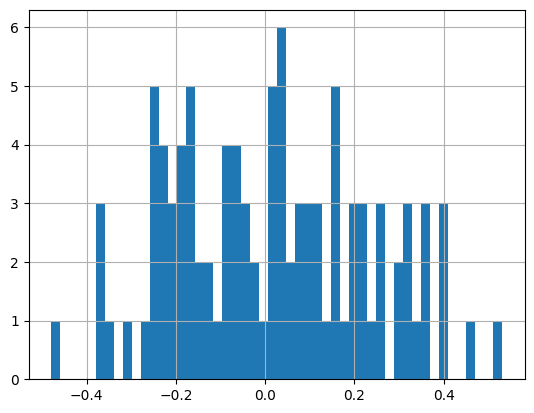

In [44]:
raw_df.iloc[0].hist(bins=50)

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

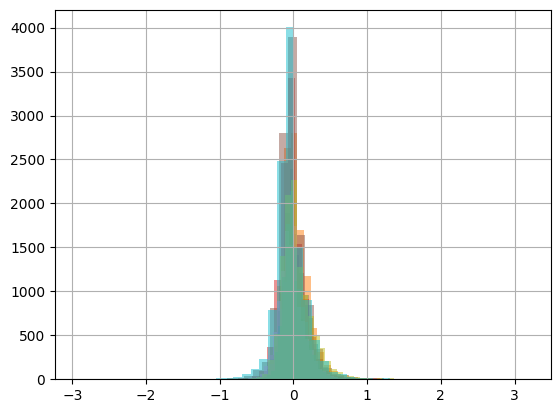

In [52]:
for i in range(10):
    display(raw_df.iloc[:,i].hist(bins=50, alpha=0.5))

In [67]:
raw_df

,BC.Elham2018.10X.C0000,BC.Elham2018.10X.C0001,BC.Elham2018.10X.C0002,BC.Elham2018.10X.C0003,BC.Elham2018.10X.C0004,BC.Elham2018.10X.C0005,BC.Elham2018.10X.C0006,BC.Elham2018.10X.C0007,BC.Elham2018.10X.C0008,BC.Elham2018.10X.C0009,...,BC.Elham2018.10X.C0090,BC.Elham2018.10X.C0091,BC.Elham2018.10X.C0092,BC.Elham2018.10X.C0093,BC.Elham2018.10X.C0094,BC.Elham2018.10X.C0095,BC.Elham2018.10X.C0096,BC.Elham2018.10X.C0097,BC.Elham2018.10X.C0098,BC.Elham2018.10X.C0099
A1BG,0.073380,0.332691,-0.240308,0.087749,0.312512,0.084108,-0.095593,0.158043,-0.186416,0.237419,...,0.108400,0.212802,0.143165,0.393101,-0.217779,0.396155,-0.177259,-0.170932,0.264727,0.042662
AAAS,0.021670,-0.089094,-0.061412,-0.024582,-0.034577,0.077058,-0.029746,0.157011,-0.057572,-0.060589,...,0.000664,0.263075,0.256452,-0.186880,0.400422,-0.190145,-0.191466,-0.085188,0.151572,0.154379
AACS,0.155467,-0.002480,0.197473,0.063601,-0.178549,-0.146376,-0.020779,-0.103957,-0.060706,0.187839,...,0.059265,-0.169059,-0.177009,-0.179284,0.338025,-0.001183,0.069908,-0.066189,0.277085,-0.148720
AAED1,0.160469,-0.061470,0.091753,-0.105919,0.080455,-0.166112,-0.326904,0.068268,-0.113974,-0.166243,...,-0.163237,-0.012106,-0.165646,0.273749,0.206829,-0.154399,-0.153587,-0.098309,-0.152516,-0.119161
AAGAB,-0.083826,-0.018445,-0.129506,0.063808,0.077301,-0.086455,0.077840,0.220727,0.026398,-0.044739,...,-0.276676,0.035141,-0.007345,-0.278500,0.704840,-0.026944,-0.092947,-0.204675,0.250074,0.259820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF837,-0.111005,-0.111556,-0.112214,0.284486,0.050951,-0.112303,-0.115588,0.093769,-0.115318,-0.112210,...,-0.115267,-0.114429,-0.115386,0.066536,-0.114654,-0.111634,-0.111907,-0.112665,0.089518,0.342899
ZNF853,-0.135424,0.299482,-0.090971,-0.121561,-0.122442,-0.080877,0.091898,0.292066,-0.115588,-0.084081,...,-0.120752,-0.116854,-0.122120,-0.120547,0.488004,-0.120831,0.275395,0.366312,-0.083711,-0.088174
ZNRF3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZP3,-0.068907,-0.064049,0.421914,-0.042843,-0.041909,0.524086,-0.041915,-0.067964,-0.046874,0.603377,...,-0.044966,-0.052659,-0.043517,-0.041621,-0.044856,-0.070839,-0.077995,-0.076608,-0.080648,-0.079610


In [88]:
raw_df.iloc[:,0].where(lambda x: ((x > 0.6) | (x < -0.6))).fillna(0).astype(bool)

A1BG       False
AAAS       False
AACS       False
AAED1      False
AAGAB      False
           ...  
ZNF837     False
ZNF853     False
ZNRF3      False
ZP3        False
ZSCAN23    False
Name: BC.Elham2018.10X.C0000, Length: 11055, dtype: bool

In [15]:
CFG.RAW_DF

,BC.Elham2018.10X.C0000,BC.Elham2018.10X.C0001,BC.Elham2018.10X.C0002,BC.Elham2018.10X.C0003,BC.Elham2018.10X.C0004,BC.Elham2018.10X.C0005,BC.Elham2018.10X.C0006,BC.Elham2018.10X.C0007,BC.Elham2018.10X.C0008,BC.Elham2018.10X.C0009,...,FTC.zhangLab5P.C0068,FTC.zhangLab5P.C0069,FTC.zhangLab5P.C0070,FTC.zhangLab5P.C0071,FTC.zhangLab5P.C0072,FTC.zhangLab5P.C0073,FTC.zhangLab5P.C0074,FTC.zhangLab5P.C0075,FTC.zhangLab5P.C0076,FTC.zhangLab5P.C0077
A1BG,0.073380,0.332691,-0.240308,0.087749,0.312512,0.084108,-0.095593,0.158043,-0.186416,0.237419,...,0.505452,0.149770,0.708835,-0.312309,-0.312309,-0.312309,-0.052114,0.215652,-0.061889,0.630138
AAAS,0.021670,-0.089094,-0.061412,-0.024582,-0.034577,0.077058,-0.029746,0.157011,-0.057572,-0.060589,...,0.433381,-0.280720,-0.280720,-0.280720,-0.280720,-0.280720,0.110699,0.370004,0.509989,-0.280720
AACS,0.155467,-0.002480,0.197473,0.063601,-0.178549,-0.146376,-0.020779,-0.103957,-0.060706,0.187839,...,-0.165876,-0.165876,-0.165876,0.662040,-0.165876,-0.165876,-0.165876,-0.165876,-0.165876,-0.165876
AAED1,0.160469,-0.061470,0.091753,-0.105919,0.080455,-0.166112,-0.326904,0.068268,-0.113974,-0.166243,...,0.008586,-0.482815,-0.482815,0.161304,-0.482815,-0.109423,0.203589,-0.030337,0.227790,-0.482815
AAGAB,-0.083826,-0.018445,-0.129506,0.063808,0.077301,-0.086455,0.077840,0.220727,0.026398,-0.044739,...,-0.271357,0.322638,1.124209,0.819718,-0.271357,0.321204,0.323078,0.407327,-0.006253,-0.271357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF837,-0.111005,-0.111556,-0.112214,0.284486,0.050951,-0.112303,-0.115588,0.093769,-0.115318,-0.112210,...,-0.050885,-0.050885,-0.050885,-0.050885,-0.050885,-0.050885,-0.050885,-0.050885,-0.050885,-0.050885
ZNF853,-0.135424,0.299482,-0.090971,-0.121561,-0.122442,-0.080877,0.091898,0.292066,-0.115588,-0.084081,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZNRF3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZP3,-0.068907,-0.064049,0.421914,-0.042843,-0.041909,0.524086,-0.041915,-0.067964,-0.046874,0.603377,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: >

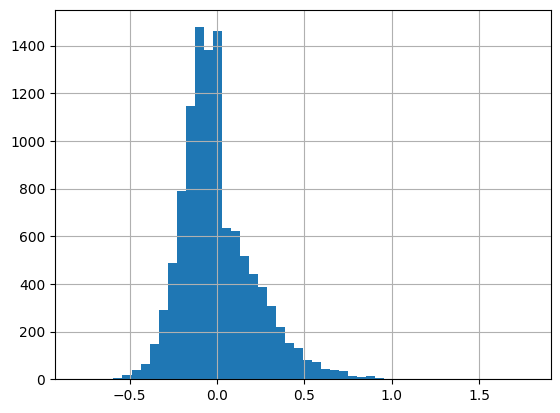

In [18]:
CFG.RAW_DF.iloc[:,188].hist(bins=50)